In [1]:
from google.cloud import storage
import pandas as pd
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def read_gcs_file(bucket_name, blob_name):
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(blob_name)

    file_content = blob.download_as_text()
    return file_content

In [3]:
def check_blob_exists(bucket_name, blob_name):
    client = storage.Client()
    bucket = client.get_bucket(bucket_name)
    blob = bucket.blob(blob_name)
    return blob.exists()

In [4]:
def get_user_interactions(user_id, max_timestamp):
    bucket_name = "run-sources-long-term-interaction-us-east5"
    interactions_file = f"interactions_{user_id}.json"
    redactions_file = f"redactions_{user_id}.json"
    
    interactions = read_gcs_file(bucket_name, interactions_file)
    interactions = [json.loads(line) for line in interactions.strip().split('\n')]
    interactions = pd.DataFrame(interactions)
    
    redactions = None
    if check_blob_exists(bucket_name, redactions_file):
        redactions = read_gcs_file(bucket_name, redactions_file)
        redactions = [json.loads(line) for line in redactions.strip().split('\n')]
        redactions = pd.DataFrame(redactions)
        redactions["message_idx"] = ((redactions["message_idx"]-1)/2).astype(int)
        redactions = redactions["message_idx"].to_list()
        print(len(redactions))
    
        interactions = interactions.drop(redactions)
        interactions = interactions.reset_index(drop=True)
    
    interactions["input"] = interactions["input"].str.strip()
    interactions["output"] = interactions["output"].str.strip()
    interactions["user_id"] = user_id
    interactions['timestamp'] = pd.to_datetime(interactions['timestamp'])
    interactions = interactions[interactions["timestamp"]<=max_timestamp]
    return interactions

In [5]:
interactions = []

MAX_TIMESTAMP_1 = "2025-08-08 19:24:44.529778"
MAX_TIMESTAMP_2 = "2025-08-08 19:24:44.529778"
MAX_TIMESTAMP_3 = "2025-08-23 15:30:01.982275"

MAX_TIMESTAMP = {
    1: pd.to_datetime(MAX_TIMESTAMP_1),
    2: pd.to_datetime(MAX_TIMESTAMP_2),
    3: pd.to_datetime(MAX_TIMESTAMP_3),
}

df = pd.read_csv("../data/participants.csv")
df = df[df["passed_attention"]=="yes"]
print(len(df))
for i,r in tqdm(df.iterrows()):
    interactions.append(get_user_interactions(r["user_id"], MAX_TIMESTAMP[r["phase"]]))

interactions = pd.concat(interactions)
interactions = interactions[interactions["input"]!=""].reset_index(drop=True)
interactions = interactions[(~interactions["input"].str.contains("GPT"))&(~interactions["output"].str.contains("GPT"))]
#interactions.to_csv("../data/interactions.csv", index=False)

38


6it [00:14,  2.34s/it]

1


8it [00:19,  2.39s/it]

1


11it [00:25,  2.41s/it]

2


14it [00:32,  2.34s/it]

1


33it [01:11,  2.28s/it]

2


34it [01:14,  2.52s/it]

7


38it [01:22,  2.16s/it]


In [7]:
max_tokens_df = interactions.groupby("user_id").max("tokens").reset_index()
print(max_tokens_df["tokens"].median())
max_tokens_df = interactions.groupby("user_id").count().reset_index()
print(max_tokens_df["tokens"].median())

33100.0
80.5


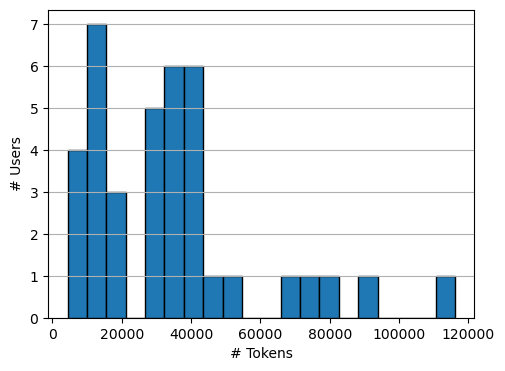

In [8]:
max_tokens_df = interactions.groupby("user_id").max("tokens").reset_index()

plt.figure(figsize=(5.5, 4))
plt.hist(max_tokens_df["tokens"], bins=20, edgecolor='black')
plt.xlabel("# Tokens")
plt.ylabel("# Users")
plt.grid(axis="y")
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig("figures/usage_tokens.jpg", dpi=300, format='jpg')
plt.show()

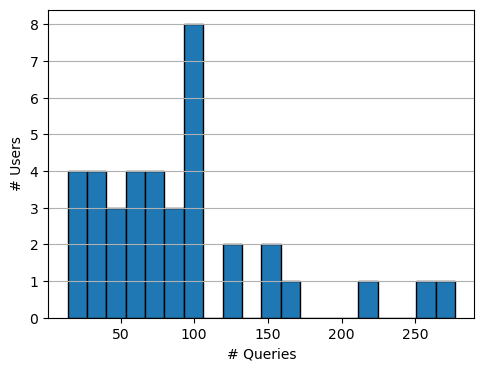

In [9]:
max_tokens_df = interactions.groupby("user_id").count().reset_index()

plt.figure(figsize=(5.5, 4))
plt.hist(max_tokens_df["tokens"], bins=20, edgecolor='black')
plt.xlabel("# Queries")
plt.ylabel("# Users")
plt.grid(axis="y")

plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.savefig("figures/usage_queries.jpg", dpi=300, format='jpg')
plt.show()

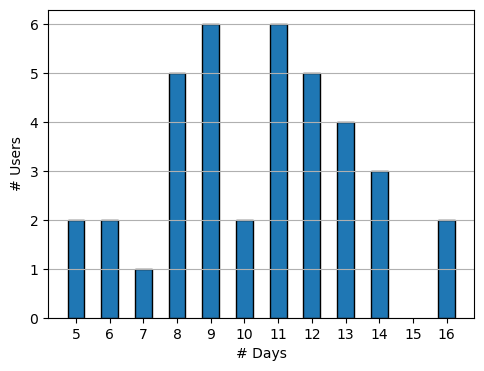

In [10]:
interactions['timestamp'] = pd.to_datetime(interactions['timestamp'])
interactions['date'] = interactions['timestamp'].dt.date

unique_days_per_user = interactions.groupby('user_id')['date'].nunique().reset_index(name='unique_days')

counts = unique_days_per_user['unique_days'].value_counts().sort_index()
x = counts.index
y = counts.values
min_val = x.min()
max_val = x.max()

plt.figure(figsize=(5.5, 4))
plt.bar(x, y, width=0.5, edgecolor='black')  # width < 1 adds space between bars
plt.xlabel('# Days')
plt.ylabel('# Users')
plt.grid(axis="y")
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.xticks(range(min_val, max_val + 1))  # Ensure integer x-ticks
plt.savefig("figures/usage_days.jpg", dpi=300, format='jpg')
plt.show()

In [11]:
interactions['date'] = pd.to_datetime(interactions['date']).dt.date
user_unique_days = interactions.groupby('user_id')['date'].nunique()
user_max_tokens = interactions.groupby('user_id')['tokens'].max()
user_num_queries = interactions.groupby('user_id').size()
user_stats = pd.DataFrame({
    'num_queries': user_num_queries,
    'max_tokens': user_max_tokens,
    'unique_days': user_unique_days
})
summary = user_stats.agg(['mean', 'std', 'min', 'max']).T

rows = [
    ('\\# Queries Per User', 'num_queries', 1),
    ('\\# Tokens Per User', 'max_tokens', 0),
    ('\\# Active Days Per User', 'unique_days', 1),
]

lines = [
    '\\begin{table*}[b!]',
    '\\small',
    '\\centering',
    '\\caption{Interaction Statistics}',
    '\\label{tab:usage}',
    '\\begin{tabular}{lcccc}',
    '\\toprule',
    ' & Average & Std Dev & Min & Max \\\\',
    '\\midrule'
]

for label, col, dec in rows:
    m, s, mn, mx = summary.loc[col]
    lines.append(f'{label} & {m:,.{dec}f} & {s:,.{dec}f} & {mn:,.{dec}f} & {mx:,.{dec}f} \\\\')

lines += [
    '\\bottomrule',
    '\\end{tabular}',
    '\\end{table*}'
]

with open('tables/usage.tex', 'w') as f:
    f.write('\n'.join(lines))
